# Iris Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Getting-Started)
3. [Generating Syntethic Data](#Conditional-Generative-Adversarial-Network)
4. [Syntethic VS Real](#Quality-assessment)
5. [Conclusion](#Conclusion)

## Libraries

In [2]:
import sys
import os

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, iqr, entropy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm

Seed function for reproducibility.

In [3]:
def set_seed(seed = 0):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [4]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Getting Started
The iris dataset will be used to validate the tabular data generation protocol, which despite its apparent simplicity may harbor pitfalls.

In [16]:
X, y = load_iris()['data'], load_iris()['target']
features, species = load_iris()['feature_names'], load_iris()['target_names']

real_iris = pd.DataFrame(X, columns = features)
real_iris['target'] = y
real_iris['target'] = real_iris['target'].map({i: species[i] for i in range(len(species))})
real_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Let's deep dive into our real data.

In [21]:
utils.describe_data(real_iris, 'target')

setosa  versicolor  virginica
MEAN sepal length (cm)   5.006       5.936      6.588
     sepal width (cm)    3.428       2.770      2.974
     petal length (cm)   1.462       4.260      5.552
     petal width (cm)    0.246       1.326      2.026
STD  sepal length (cm)   0.352       0.516      0.636
     sepal width (cm)    0.379       0.314      0.322
     petal length (cm)   0.174       0.470      0.552
     petal width (cm)    0.105       0.198      0.275
MIN  sepal length (cm)   4.300       4.900      4.900
     sepal width (cm)    2.300       2.000      2.200
     petal length (cm)   1.000       3.000      4.500
     petal width (cm)    0.100       1.000      1.400
MAX  sepal length (cm)   5.800       7.000      7.900
     sepal width (cm)    4.400       3.400      3.800
     petal length (cm)   1.900       5.100      6.900
     petal width (cm)    0.600       1.800      2.500
SKEW sepal length (cm)   0.116       0.102      0.114
     sepal width (cm)    0.040      -0.352      0.355
     petal length (cm)   0.103      -0.588      0.533
     petal width (cm)    1.216      -0.030     -0.126
KURT sepal length (cm)  -0.346      -0.599     -0.088
     sepal width (cm)    0.744      -0.448      0.520
     petal length (cm)   0.805      -0.074     -0.256
     petal width (cm)    1.434      -0.488     -0.661
IQR  sepal length (cm)   0.400       0.700      0.675
     sepal width (cm)    0.475       0.475      0.375
     petal length (cm)   0.175       0.600      0.775
     petal width (cm)    0.100       0.300      0.500

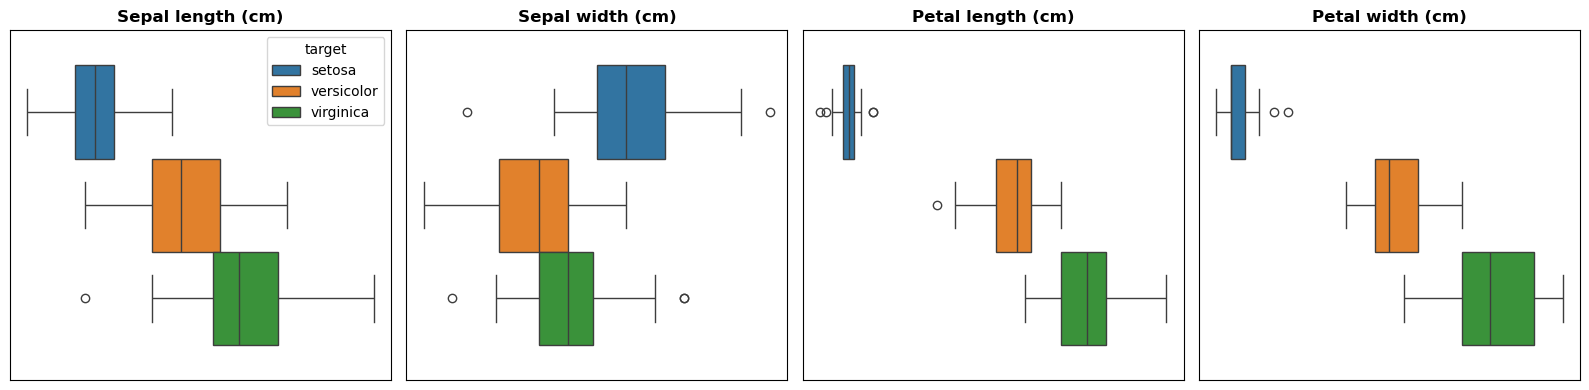

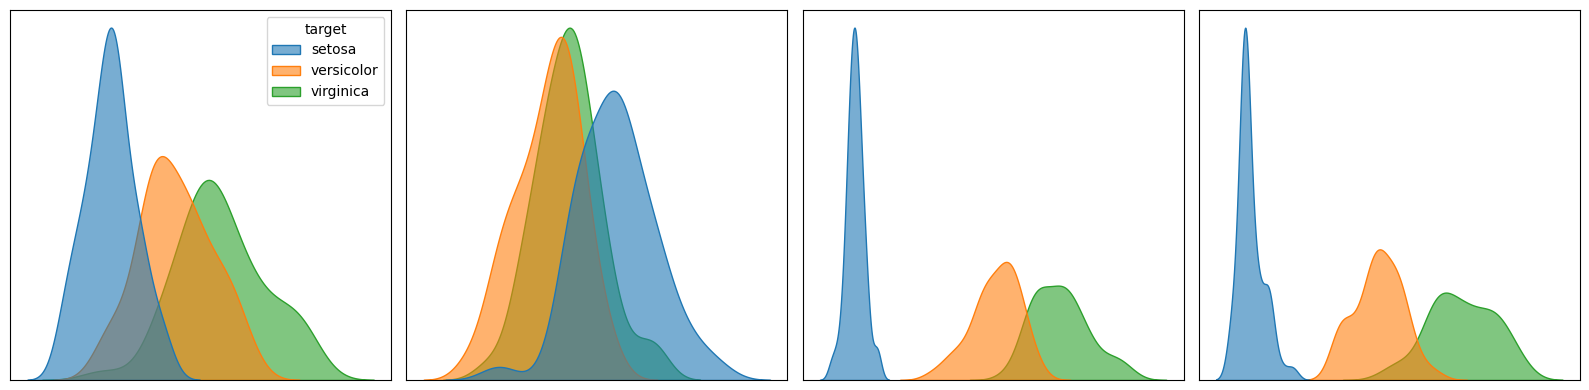

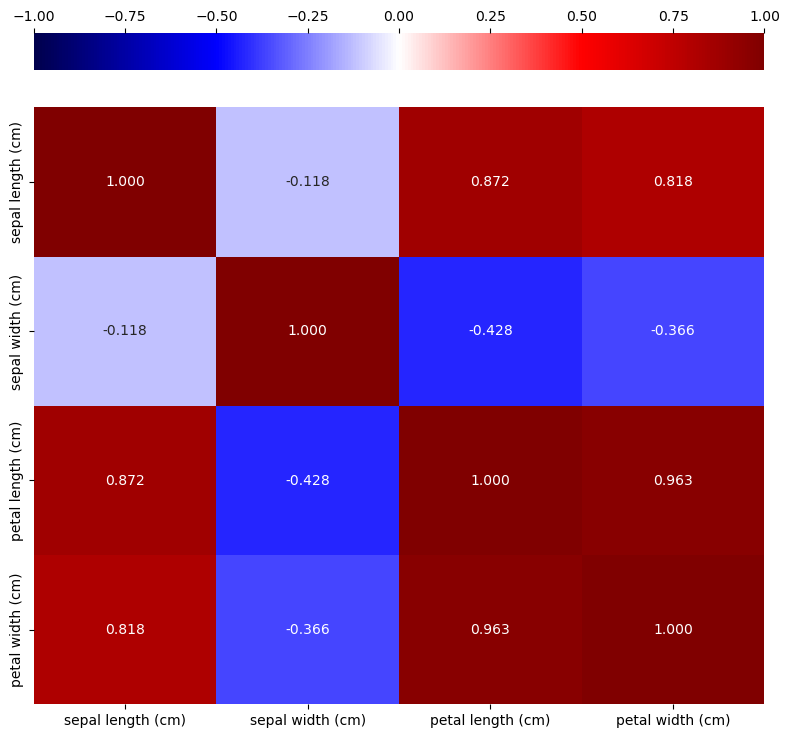

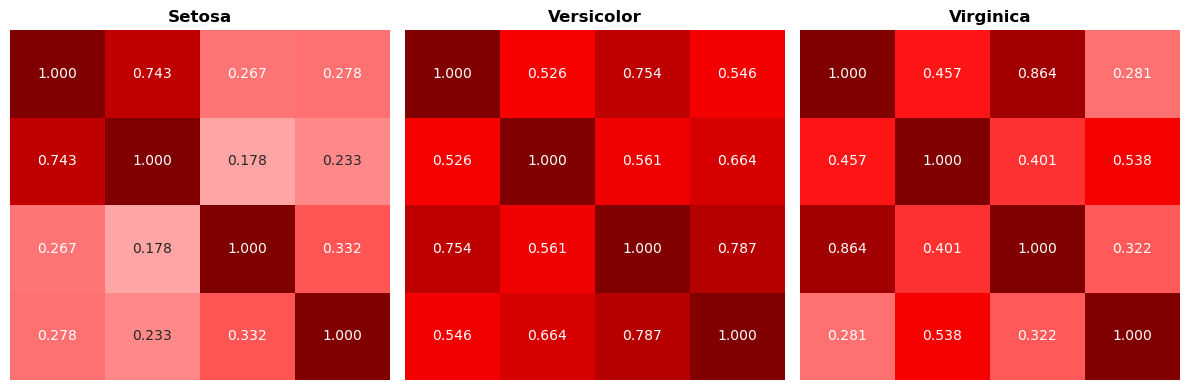

In [22]:
utils.plot_data(real_iris, 'target')

Throughout the notebook we will make comparisons between two datasets, one real and one synthetic; the following dataset, generated by adding normal noise to the real one, is used to introduce the comparison functions.

In [7]:
df = real_iris.select_dtypes('number') + np.random.normal(0, 1, (150,4))
df['target'] = real_iris['target']
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,3.853162,2.216950,3.085365,0.246729,setosa
1,4.377771,2.937775,2.849088,1.109958,setosa
2,4.780609,2.761939,1.757822,-0.107599,setosa
3,6.075289,2.354430,1.426293,-0.531558,setosa
4,5.677520,3.396639,1.632640,-0.860634,setosa


Let's start with comparisons! 

First of all a simply comparison between descriptives.